[[  20.04619731]
 [ -57.83017891]
 [  46.75477477]
 [  40.09239461]
 [-115.66035782]
 [  93.50954954]]
[[   5.14932612]
 [-212.45547345]
 [ 164.51991223]
 [ -69.88613698]
 [-193.59023126]
 [ 142.02072538]]
[[-106.21298094]
 [-341.69173266]
 [ 281.40053969]
 [-152.83847716]
 [ -64.88228715]
 [  91.74052956]]
[[-245.95495214]
 [-373.5484311 ]
 [ 369.18407459]
 [-126.64546524]
 [   1.16889026]
 [  83.82654022]]
[[-413.88284579]
 [-345.56612739]
 [ 543.02719981]
 [-209.21032204]
 [  54.79571717]
 [ 263.85971023]]
X: (5, 1)
Y: (5, 6)


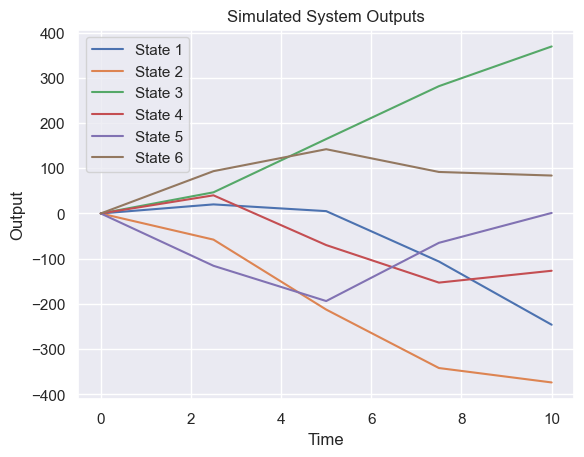

In [427]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import *
import numpy as np
from state_space_kernel import StateSpaceKernel, RationalQuadratic
import matplotlib.pyplot as plt
import seaborn as sns
from control import *
# %load_ext autoreload
%autoreload 2

sns.set_theme(style="darkgrid")

# Create SS Model
m=1.0
I=1.0
q=1.0
r=1.0
dt=1.0

M = np.diag([m, m, I])
A = np.zeros((6, 6))
A[0:3, 3:6] = np.eye(3)
B = np.zeros((6, 3))
B[3:6, 0:3] = np.diag([1/m, 1/m, 1/I])
C = np.eye(6)
D = np.zeros((6, 3))
sys = ss(A, B, C, D)
# print(sys)
# Discretize the system
sysd = c2d(sys, Ts=dt)
# print(sysd)


t = np.linspace(0, 10, num=5)
# t = np.sort(np.random.uniform(0, 10, size=10))  # Generate random time points and sort them

# Generate state-space dataset
X = t.reshape(-1, 1)  # Input is time
Y = []

# Initial state
x = np.zeros((6, 1))
for time in t:
    # Simulate the state-space model
    x_kp1 = sysd.A @ x + sysd.B @ (100 * np.random.randn(3, 1))  # Random input for simulation
    print(x_kp1)
    y_k = sysd.C @ x + sysd.D @ np.random.randn(3, 1)  # Measurement with noise
    Y.append(y_k.flatten())
    
    x = x_kp1  # Update state for next iteration

Y = np.array(Y)  # Output is 6D measurement

print(f"X: {X.shape}")
print(f"Y: {Y.shape}")

# print(Y)
for state in range(6):
    plt.plot(X, Y[:, state], label=f'State {state + 1}')
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('Simulated System Outputs')
plt.legend()
plt.show()

Custom Kernel

In [428]:
kernel = StateSpaceKernel()
print("Theta:", kernel.theta)
print("Bounds:", kernel.bounds)

Theta: [ 0.         11.51292546  0.          0.        ]
Bounds: [[  6.90775528  13.81551056]
 [  9.21034037  13.81551056]
 [-11.51292546   4.60517019]
 [-11.51292546   4.60517019]]


# Independent state gaussian process

State 1 kernel: RBF(length_scale=1.16)
State 2 kernel: RBF(length_scale=1.37)
State 3 kernel: RBF(length_scale=1.38)
State 4 kernel: RBF(length_scale=0.796)
State 5 kernel: RBF(length_scale=1e-05)
State 6 kernel: RBF(length_scale=1e-05)


/opt/homebrew/Caskroom/miniconda/base/envs/gp/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/gp/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


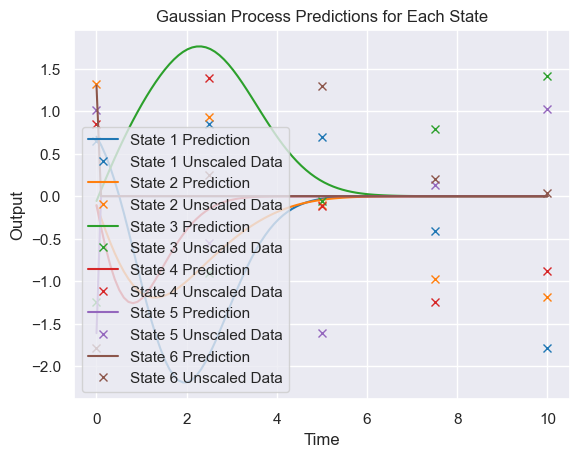

In [429]:
from sklearn.preprocessing import StandardScaler

# Normalize and scale the data
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y)


# Fit Gaussian Process for each state
gprs = []
# gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True)
kernel = RBF() 

for state in range(6):
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True)
    gpr.fit(X_scaled, Y_scaled[:, state])  # Use the state-specific output
    gprs.append(gpr)
    print(f"State {state + 1} kernel: {gpr.kernel_}")
    

colors = sns.color_palette("tab10", n_colors=6)
# Predict and plot for each state
t_test = np.linspace(0, 10, num=100).reshape(-1, 1)  # Test time points
for state in range(6):
    y_pred, y_std = gprs[state].predict(t_test, return_std=True)
    plt.plot(t_test, y_pred, label=f'State {state + 1} Prediction', color=colors[state])
    # plt.fill_between(
    #     t_test.ravel(),
    #     scaler_Y.inverse_transform((y_pred - 1.96 * y_std).reshape(-1, 1))[:, state],
    #     scaler_Y.inverse_transform((y_pred + 1.96 * y_std).reshape(-1, 1))[:, state],
    #     alpha=0.2
    # )
    # Plot unscaled data points
    plt.plot(X, Y_scaled[:, state], 'x', color=colors[state], label=f'State {state + 1} Unscaled Data')
    # # Plot original data points
    # plt.plot(X, Y[:, state], 'o', color=colors[state])
    
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('Gaussian Process Predictions for Each State')
plt.legend()
plt.show()